In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Configuration
input_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/plots"
output_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/matrix"
input_shape = (1000, 400, 1)  # Assuming grayscale images
output_shape = (50, 50, 1)     # Assuming grayscale images
batch_size = 8
patch_size = 50  # Size of the patches to be extracted from the input images
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
num_heads = 4
transformer_layers = 8
learning_rate = 0.001
epochs = 50



In [3]:
# Data Generator
class ImageDataGenerator(Sequence):
    def __init__(self, input_dir, output_dir, batch_size, input_shape, output_shape):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        # Get all valid pairs
        self.pairs = []
        for filename in os.listdir(input_dir):
            if filename.startswith("graph_") and filename.endswith(".png"):
                x = filename[6:-4]
                output_path = os.path.join(output_dir, f"{x}.png")
                if os.path.exists(output_path):
                    self.pairs.append((os.path.join(input_dir, filename), output_path))
        
        # Shuffle pairs
        np.random.shuffle(self.pairs)
    
    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_pairs = self.pairs[idx*self.batch_size : (idx+1)*self.batch_size]
        
        batch_input = np.zeros((len(batch_pairs), *self.input_shape))
        batch_output = np.zeros((len(batch_pairs), *self.output_shape))
        
        for i, (input_path, output_path) in enumerate(batch_pairs):
            # Load and preprocess input image
            input_img = Image.open(input_path).convert('L')  # Convert to grayscale
            input_img = input_img.resize((self.input_shape[1], self.input_shape[0]))
            input_img = np.array(input_img) / 255.0
            input_img = np.expand_dims(input_img, axis=-1)
            batch_input[i] = input_img
            
            # Load and preprocess output image
            output_img = Image.open(output_path).convert('L')  # Convert to grayscale
            output_img = output_img.resize((self.output_shape[1], self.output_shape[0]))
            output_img = np.array(output_img) / 255.0
            output_img = np.expand_dims(output_img, axis=-1)
            batch_output[i] = output_img
        
        return batch_input, batch_output



In [4]:
# Create patches from images
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches



In [5]:
# Patch encoder
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [6]:
# Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res



In [8]:
# Build the ViT model
def build_vit_model(input_shape, output_shape, patch_size, num_patches, projection_dim, num_heads, transformer_layers):
    inputs = layers.Input(shape=input_shape)
    
    # Create patches
    patches = Patches(patch_size)(inputs)
    
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Transformer blocks
    for _ in range(transformer_layers):
        encoded_patches = transformer_encoder(encoded_patches, projection_dim, num_heads, projection_dim*2)
    
    # Reshape and upsample to output size
    x = layers.Reshape((input_shape[0] // patch_size, input_shape[1] // patch_size, projection_dim))(encoded_patches)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Final resize to output shape
    x = tf.image.resize(x, output_shape[:2])
    
    model = models.Model(inputs=inputs, outputs=x)
    return model

In [7]:
# Custom layer for resizing
class ResizeLayer(layers.Layer):
    def __init__(self, target_size, **kwargs):
        super(ResizeLayer, self).__init__(**kwargs)
        self.target_size = target_size
    
    def call(self, inputs):
        return tf.image.resize(inputs, self.target_size)
    
    def get_config(self):
        config = super().get_config()
        config.update({"target_size": self.target_size})
        return config

# Updated build_vit_model function
def build_vit_model(input_shape, output_shape, patch_size, num_patches, projection_dim, num_heads, transformer_layers):
    inputs = layers.Input(shape=input_shape)
    
    # Create patches
    patches = Patches(patch_size)(inputs)
    
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Transformer blocks
    for _ in range(transformer_layers):
        encoded_patches = transformer_encoder(encoded_patches, projection_dim, num_heads, projection_dim*2)
    
    # Reshape and upsample to output size
    x = layers.Reshape((input_shape[0] // patch_size, input_shape[1] // patch_size, projection_dim))(encoded_patches)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Use our custom resize layer instead of tf.image.resize directly
    x = ResizeLayer(output_shape[:2])(x)
    
    model = models.Model(inputs=inputs, outputs=x)
    return model

In [8]:
# Create data generators
train_generator = ImageDataGenerator(input_dir, output_dir, batch_size, input_shape, output_shape)

# Build and compile the model
model = build_vit_model(input_shape, output_shape, patch_size, num_patches, projection_dim, num_heads, transformer_layers)
model.compile(optimizer=optimizers.Adam(learning_rate), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(train_generator, epochs=epochs)

# Save the model
model.save("vit_image_translation_model.h5")

C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 206s 516ms/step - loss: 0.2506 - mae: 0.5001
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 78s 530ms/step - loss: 0.2501 - mae: 0.5000
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 54s 364ms/step - loss: 0.2501 - mae: 0.5000
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 77s 526ms/step - loss: 0.2500 - mae: 0.4999
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 75s 511ms/step - loss: 0.2500 - mae: 0.5000
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 48s 325ms/step - loss: 0.2500 - mae: 0.5000
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - loss: 0.2500 - mae: 0.5000
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 287ms/step - loss: 0.2500 - mae: 0.5000
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 300ms/step - loss: 0.2500 - mae: 0.4999
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 297ms/step - loss: 0.2500 - mae: 0.5000
Epoch 11/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - loss: 0.2500 - mae: 0.5000
Epoch 12/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 67s 180ms/step - loss: 0.2499 - 

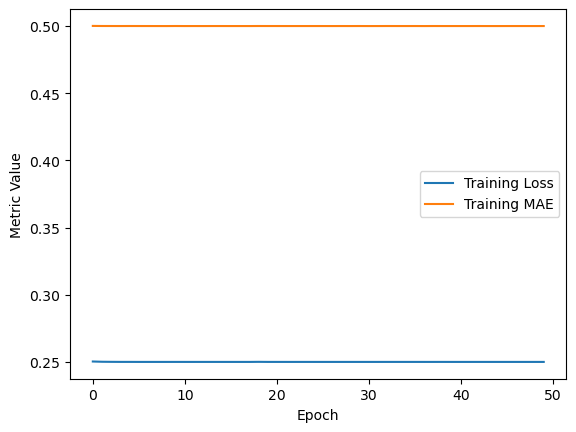

In [9]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['mae'], label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.2504 - mae: 0.5000

C:\Users\User\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):
C:\Users\User\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae
  current = self.get_monitor_value(logs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 33s 113ms/step - loss: 0.2504 - mae: 0.5000
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2501 - mae: 0.4998

146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - loss: 0.2501 - mae: 0.4998
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - loss: 0.2500 - mae: 0.4999
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - loss: 0.2500 - mae: 0.5000
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - loss: 0.2500 - mae: 0.5000
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 0.2500 - mae: 0.5000
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - loss: 0.2500 - mae: 0.5000
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 0.2500 - mae: 0.5000
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 0.2500 - mae: 0.4999
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - loss: 0.2500 - mae: 0.5000
Epoch 11/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - loss: 0.2500 - mae: 0.5000
Epoch 12/50
145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 124ms/step - loss: 0.2500 - mae: 0.5000
Epoch 13/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - loss: 0.2500 - mae: 0.5000
Epoch 14/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 0.2500 - mae: 0.5000
Epoch 15/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 0.2500 - mae: 0.4999
Epoch 16/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - loss: 0.2500 - mae: 0.5000
Epoch 17/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.2500 - mae: 0.4999
Epoch 18/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - loss: 0.2500 - mae: 0.5000
Epoch 19/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 0.2500 - mae: 0.5000
Epoch 20/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 0.2500 - mae: 0.5000
Epoch 21/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - loss: 0.2500 - mae: 0.5000
Epoch 22/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 0.2500 - mae: 0.4999
Epoch 23/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.2500 - mae: 0.5000
Epoch 24/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.2500 - mae: 0.5000
Epoch 25/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - loss: 0.2500 - mae: 0.5000
Epoch 26/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.2500 - mae: 0.5000
Epoch 27/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - loss: 0.2500 - mae: 0.4999
Epoch 28/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - loss: 0.2500 - mae: 0.4999
Epoch 29/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - loss: 0.2500 - mae: 0.5000
Epoch 30/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2499 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.2499 - mae: 0.4999
Epoch 31/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.2499 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 0.2499 - mae: 0.4999
Epoch 32/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - loss: 0.2500 - mae: 0.4999
Epoch 33/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - loss: 0.2500 - mae: 0.5000
Epoch 34/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2499 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 0.2499 - mae: 0.4999
Epoch 35/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 0.2500 - mae: 0.5000
Epoch 36/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 0.2500 - mae: 0.5000
Epoch 37/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 0.2500 - mae: 0.4999
Epoch 38/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2499 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - loss: 0.2499 - mae: 0.4999
Epoch 39/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - loss: 0.2500 - mae: 0.5000
Epoch 40/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - loss: 0.2500 - mae: 0.5000
Epoch 41/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - loss: 0.2500 - mae: 0.5000
Epoch 42/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.2499 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - loss: 0.2499 - mae: 0.4999
Epoch 43/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - loss: 0.2500 - mae: 0.5000
Epoch 44/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - loss: 0.2500 - mae: 0.5000
Epoch 45/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.2500 - mae: 0.4999
Epoch 46/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - loss: 0.2500 - mae: 0.4999
Epoch 47/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.2500 - mae: 0.5000

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 0.2500 - mae: 0.5000
Epoch 48/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - loss: 0.2500 - mae: 0.4999
Epoch 49/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2499 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 0.2499 - mae: 0.4999
Epoch 50/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.2500 - mae: 0.4999

146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - loss: 0.2500 - mae: 0.4999


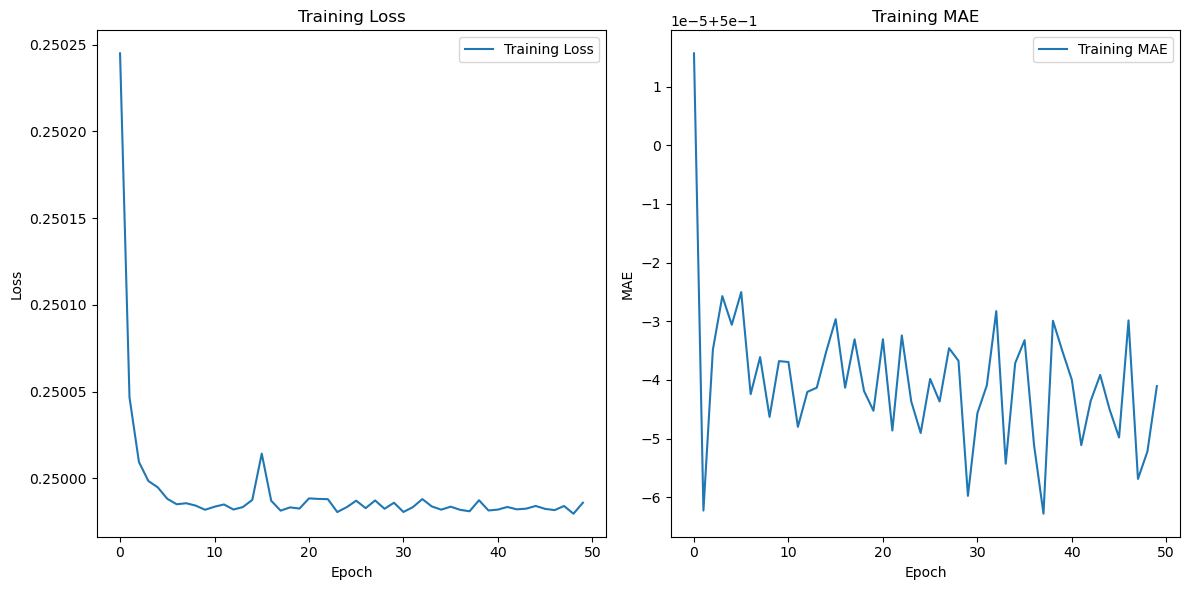

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import Sequence
from PIL import Image
import matplotlib.pyplot as plt

# Suppress TensorFlow placeholder warning (optional)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Configuration
input_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/plots"
output_dir = "F:/Education/NSU/CSE/CSE499/Implementation/Image Data/matrix"
input_shape = (1000, 400, 1)  # Grayscale images
output_shape = (50, 50, 1)    # Grayscale images
batch_size = 8
patch_size = 50
projection_dim = 64
num_heads = 4
transformer_layers = 8
learning_rate = 0.001
epochs = 50

# Calculate number of patches
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)

# Updated Data Generator with proper super() call
class ImageDataGenerator(Sequence):
    def __init__(self, input_dir, output_dir, batch_size, input_shape, output_shape, **kwargs):
        super().__init__(**kwargs)  # This addresses the PyDataset warning
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.output_shape = output_shape
        
        # Get all valid pairs
        self.pairs = []
        for filename in os.listdir(input_dir):
            if filename.startswith("graph_") and filename.endswith(".png"):
                x = filename[6:-4]
                output_path = os.path.join(output_dir, f"{x}.png")
                if os.path.exists(output_path):
                    self.pairs.append((os.path.join(input_dir, filename), output_path))
        
        # Shuffle pairs
        np.random.shuffle(self.pairs)
    
    def __len__(self):
        return int(np.ceil(len(self.pairs) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_pairs = self.pairs[idx*self.batch_size : (idx+1)*self.batch_size]
        
        batch_input = np.zeros((len(batch_pairs), *self.input_shape))
        batch_output = np.zeros((len(batch_pairs), *self.output_shape))
        
        for i, (input_path, output_path) in enumerate(batch_pairs):
            # Load and preprocess input image
            input_img = Image.open(input_path).convert('L')
            input_img = input_img.resize((self.input_shape[1], self.input_shape[0]))
            input_img = np.array(input_img) / 255.0
            input_img = np.expand_dims(input_img, axis=-1)
            batch_input[i] = input_img
            
            # Load and preprocess output image
            output_img = Image.open(output_path).convert('L')
            output_img = output_img.resize((self.output_shape[1], self.output_shape[0]))
            output_img = np.array(output_img) / 255.0
            output_img = np.expand_dims(output_img, axis=-1)
            batch_output[i] = output_img
        
        return batch_input, batch_output

# [Rest of your implementation remains the same...]
# Keep the Patches, PatchEncoder, transformer_encoder, ResizeLayer, and build_vit_model 
# implementations exactly as shown in the previous corrected version

# Create data generators
train_generator = ImageDataGenerator(
    input_dir, 
    output_dir, 
    batch_size, 
    input_shape, 
    output_shape
)

# Build and compile the model
model = build_vit_model(
    input_shape, 
    output_shape, 
    patch_size, 
    num_patches, 
    projection_dim, 
    num_heads, 
    transformer_layers
)
model.compile(
    optimizer=optimizers.Adam(learning_rate), 
    loss='mse', 
    metrics=['mae']
)

# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5', 
        save_best_only=True, 
        monitor='val_loss'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5, 
        restore_best_weights=True
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save("vit_image_translation_model_final.h5")

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.title('Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

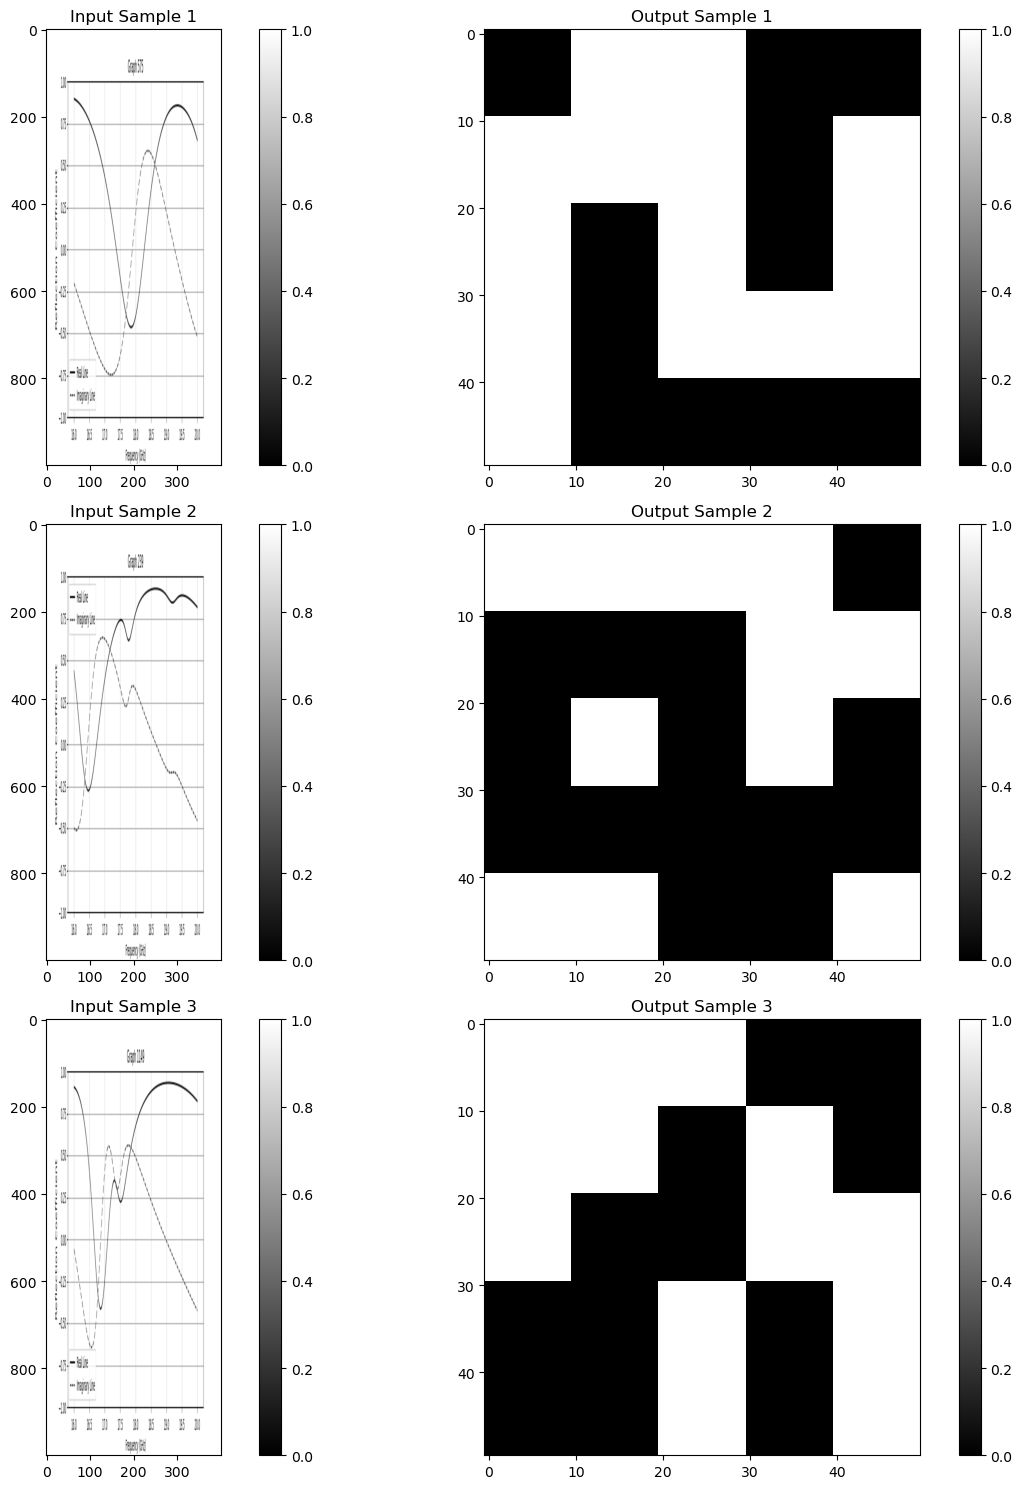

In [14]:
def visualize_samples(generator, num_samples=3):
    # Get a batch of data
    inputs, outputs = generator[0]  # Get first batch
    
    plt.figure(figsize=(15, 5*num_samples))
    
    for i in range(min(num_samples, len(inputs))):
        # Input image (1000x400)
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(inputs[i].squeeze(), cmap='gray')
        plt.title(f'Input Sample {i+1}')
        plt.colorbar()
        
        # Output image (50x50)
        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        plt.title(f'Output Sample {i+1}')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# Visualize 3 samples from your training data
visualize_samples(train_generator, num_samples=3)


Final prediction analysis:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step


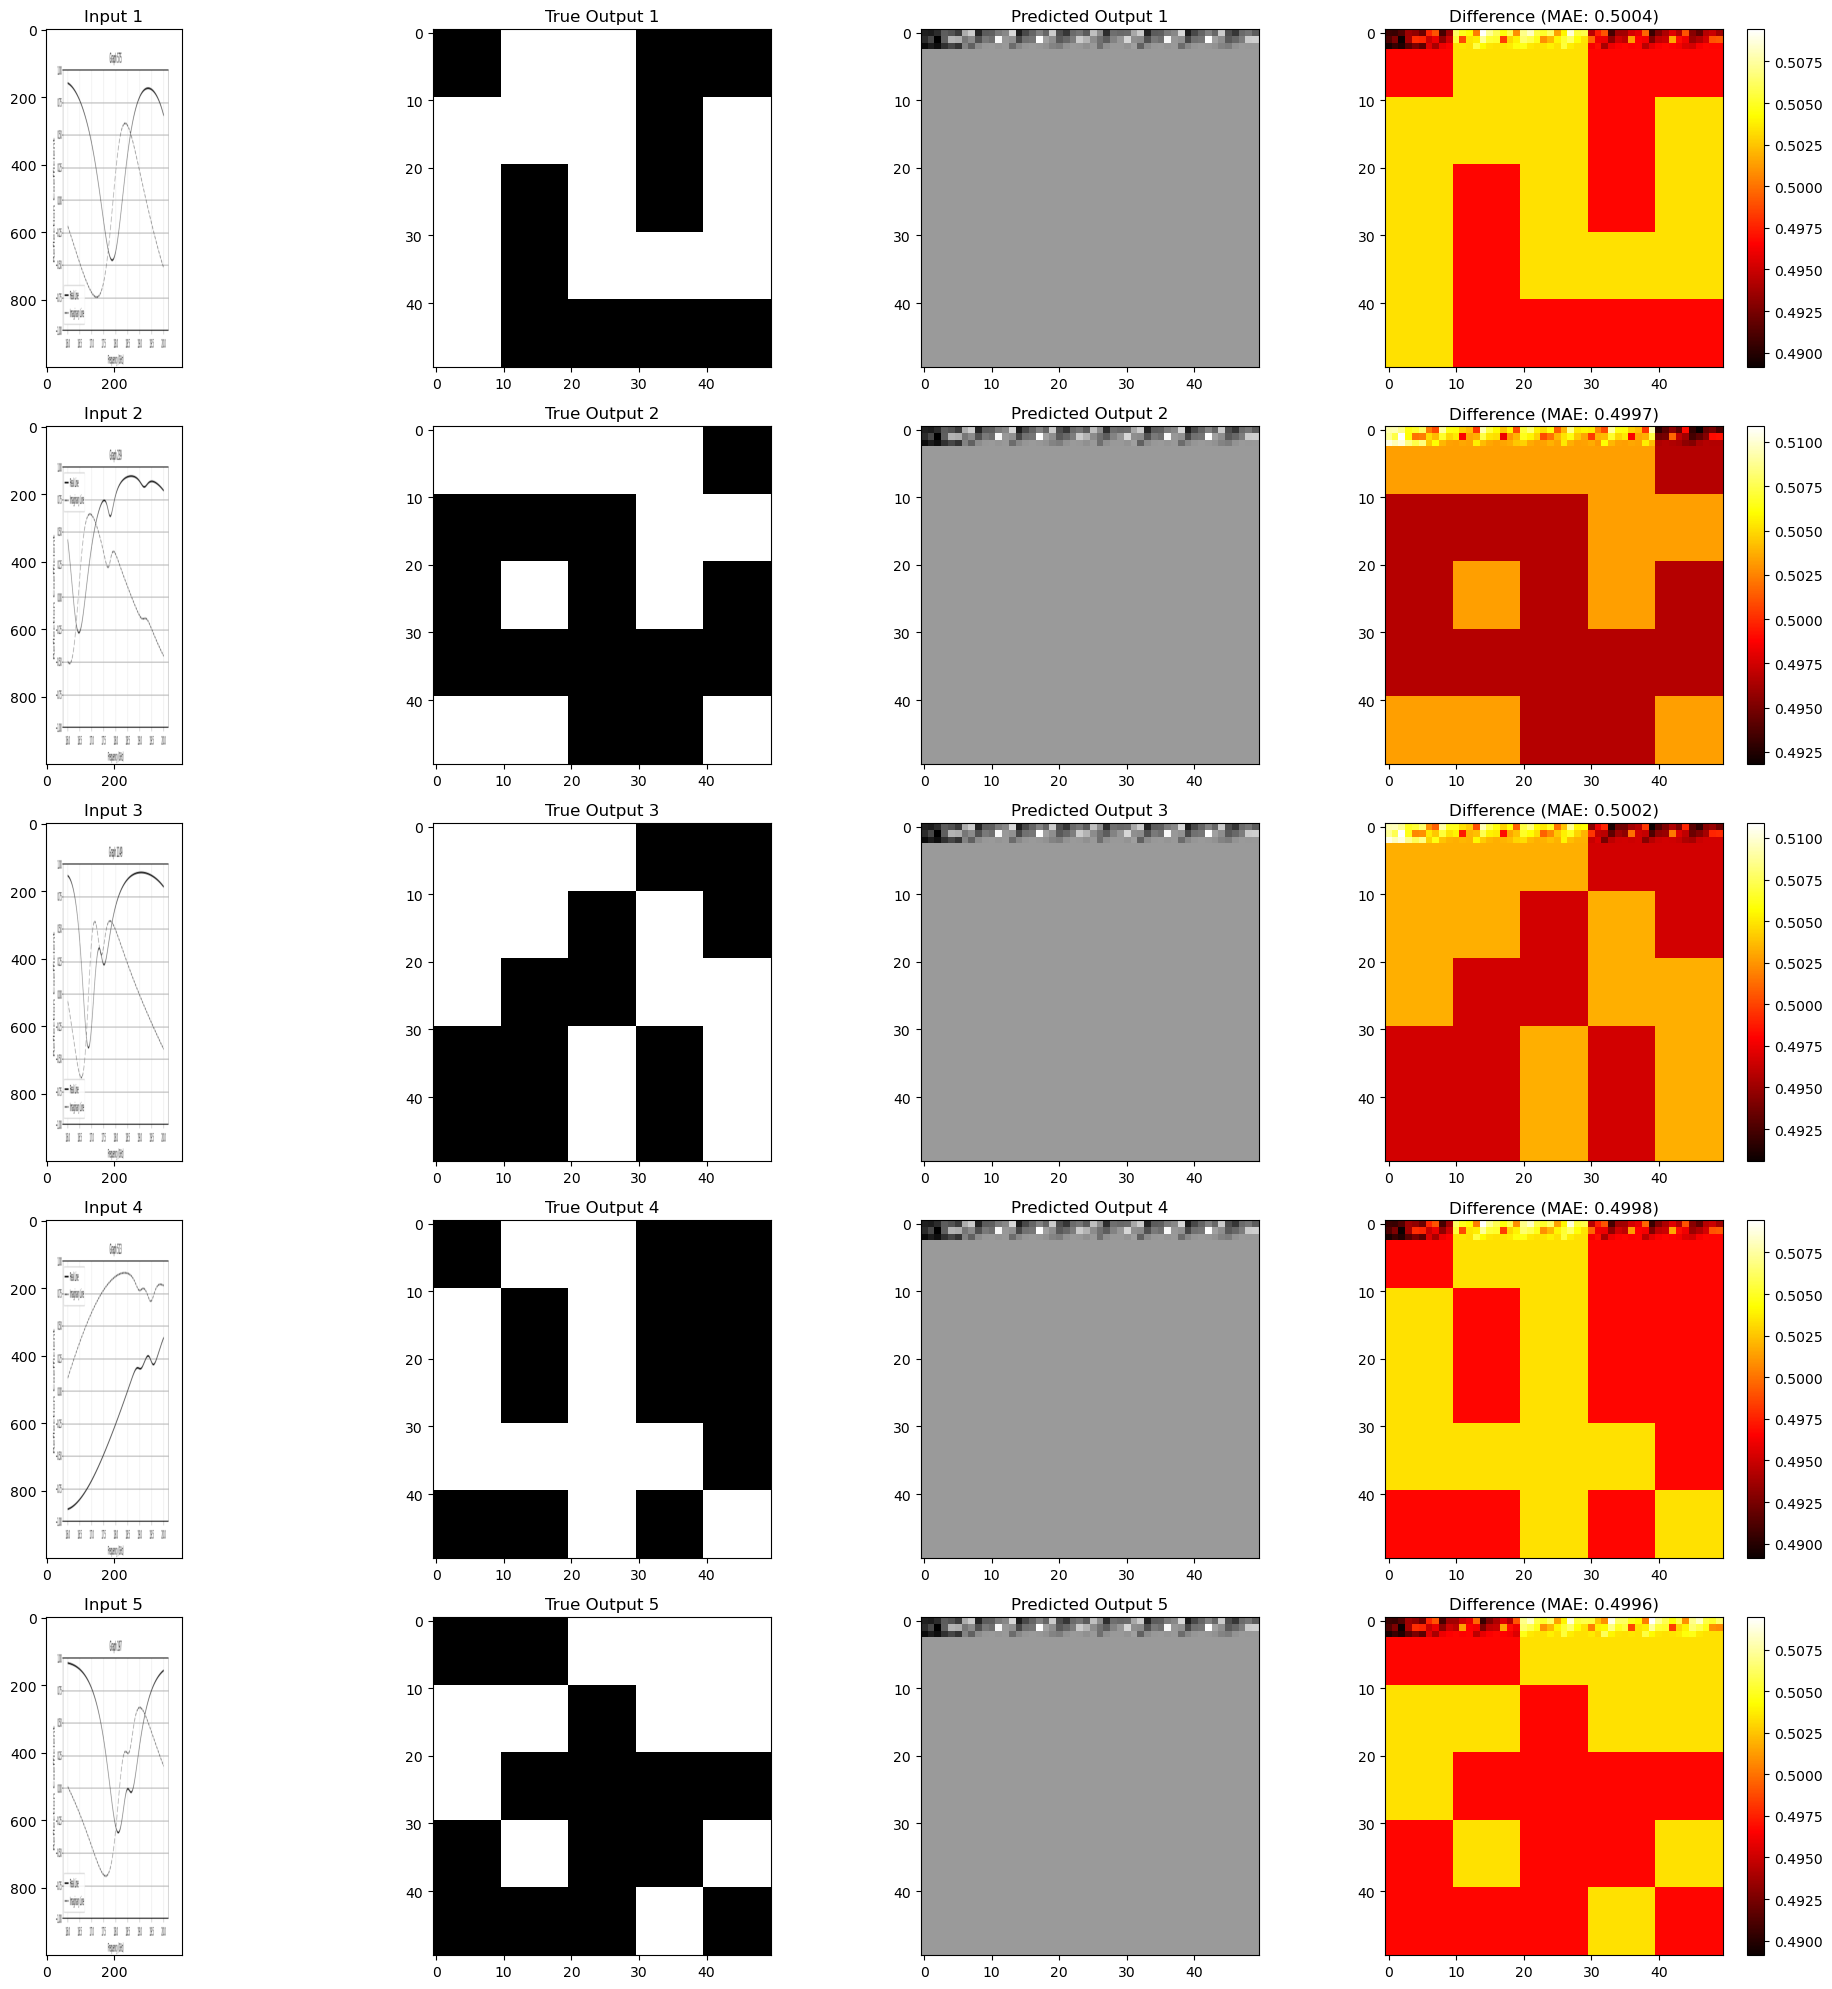

In [15]:
def analyze_results(model, generator, num_samples=5):
    inputs, true_outputs = generator[0]
    preds = model.predict(inputs[:num_samples])
    
    plt.figure(figsize=(20, 4*num_samples))
    
    for i in range(num_samples):
        # Input
        plt.subplot(num_samples, 4, 4*i+1)
        plt.imshow(inputs[i].squeeze(), cmap='gray')
        plt.title(f'Input {i+1}')
        
        # True output
        plt.subplot(num_samples, 4, 4*i+2)
        plt.imshow(true_outputs[i].squeeze(), cmap='gray')
        plt.title(f'True Output {i+1}')
        
        # Predicted output
        plt.subplot(num_samples, 4, 4*i+3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title(f'Predicted Output {i+1}')
        
        # Difference
        plt.subplot(num_samples, 4, 4*i+4)
        diff = np.abs(true_outputs[i].squeeze() - preds[i].squeeze())
        plt.imshow(diff, cmap='hot')
        plt.title(f'Difference (MAE: {diff.mean():.4f})')
        plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# After training
print("\nFinal prediction analysis:")
analyze_results(model, train_generator)

In [20]:
def evaluate_model(model, generator):
    # Calculate standard metrics
    loss, mae = model.evaluate(generator, verbose=0)
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Mean Squared Error: {loss:.4f}")
    
    # Get sample batch
    inputs, true_outputs = generator[0]
    preds = model.predict(inputs)
    
    # Convert to float64 for SSIM/PSNR calculations
    true_tensor = tf.convert_to_tensor(true_outputs, dtype=tf.float64)
    pred_tensor = tf.convert_to_tensor(preds, dtype=tf.float64)
    
    try:
        # Structural Similarity Index (SSIM)
        ssim = tf.image.ssim(
            true_tensor,
            pred_tensor,
            max_val=1.0
        ).numpy().mean()
        print(f"Structural Similarity (SSIM): {ssim:.4f}")
        
        # Peak Signal-to-Noise Ratio (PSNR)
        psnr = tf.image.psnr(
            true_tensor,
            pred_tensor,
            max_val=1.0
        ).numpy().mean()
        print(f"Peak SNR (PSNR): {psnr:.2f} dB")
        
        return {
            'mae': mae,
            'mse': loss,
            'ssim': ssim,
            'psnr': psnr
        }
        
    except Exception as e:
        print(f"Error calculating quality metrics: {str(e)}")
        return {
            'mae': mae,
            'mse': loss,
            'ssim': None,
            'psnr': None
        }

# Run evaluation
metrics = evaluate_model(model, train_generator)

Mean Absolute Error: 0.5000
Mean Squared Error: 0.2500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Structural Similarity (SSIM): 0.1211
Peak SNR (PSNR): 6.02 dB


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


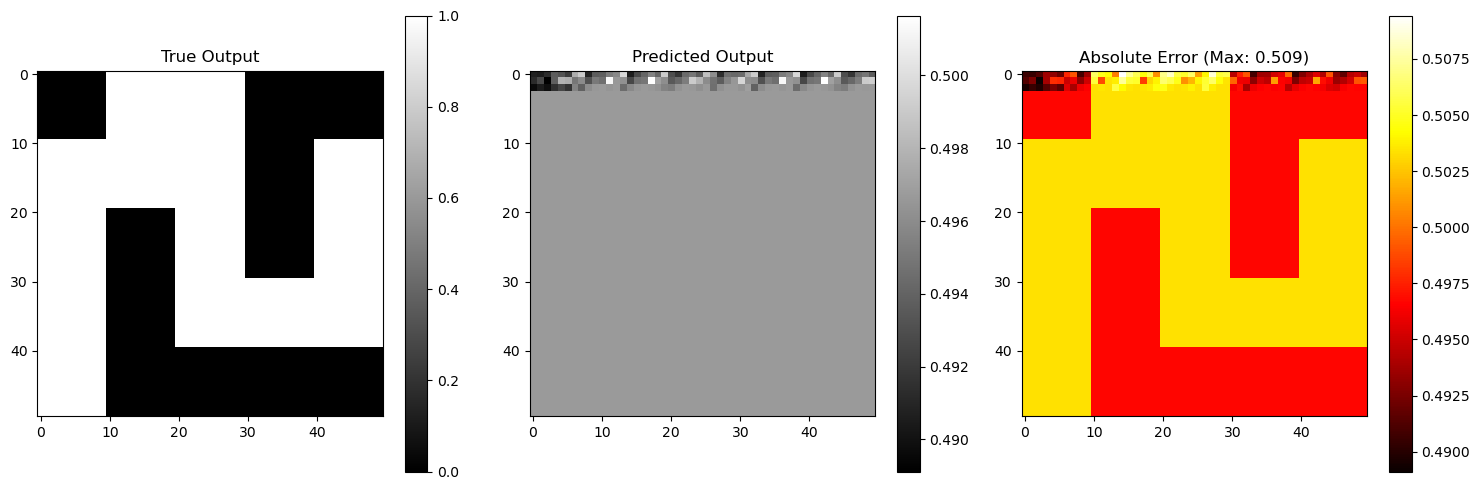

In [18]:
def plot_error_heatmaps(true, pred, sample_idx=0):
    plt.figure(figsize=(15, 5))
    
    # Absolute error
    abs_error = np.abs(true[sample_idx].squeeze() - pred[sample_idx].squeeze())
    
    plt.subplot(1, 3, 1)
    plt.imshow(true[sample_idx].squeeze(), cmap='gray')
    plt.title('True Output')
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(pred[sample_idx].squeeze(), cmap='gray')
    plt.title('Predicted Output')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.imshow(abs_error, cmap='hot')
    plt.title(f'Absolute Error (Max: {abs_error.max():.3f})')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

# Generate predictions
sample_inputs, sample_true = train_generator[0]
sample_preds = model.predict(sample_inputs)

# Plot heatmaps
plot_error_heatmaps(sample_true, sample_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

WORST PERFORMING SAMPLES:


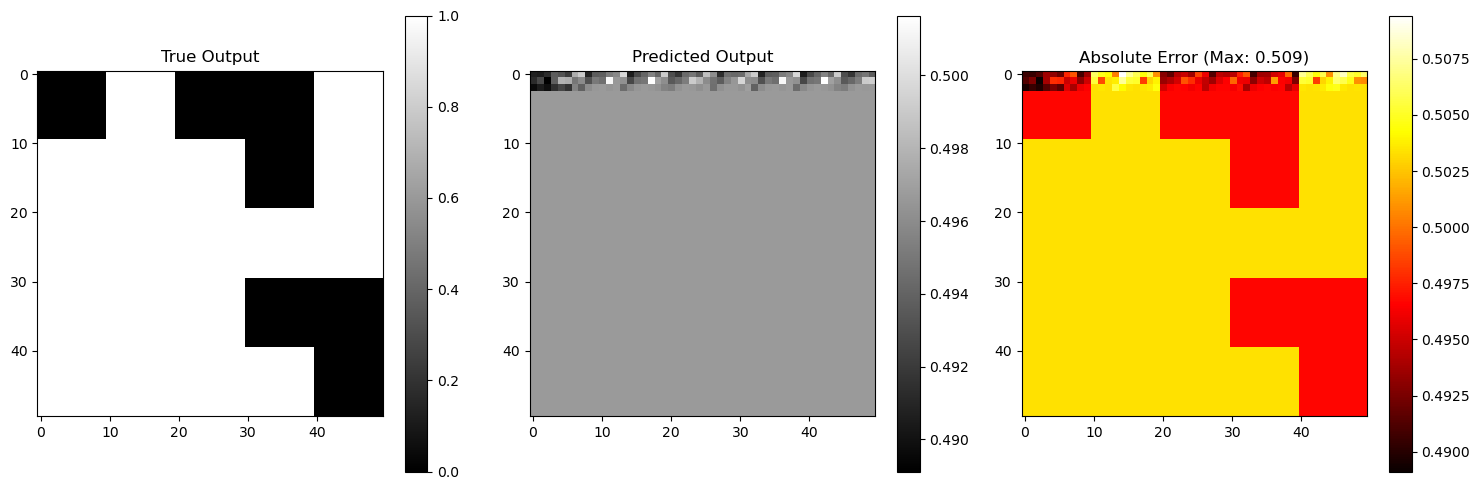

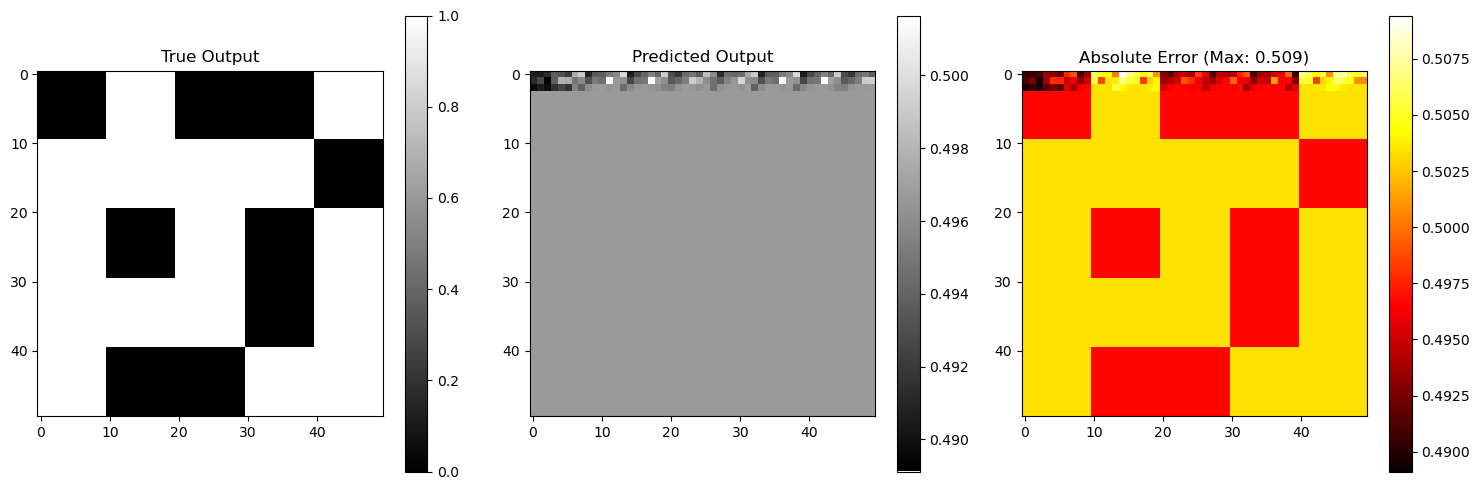

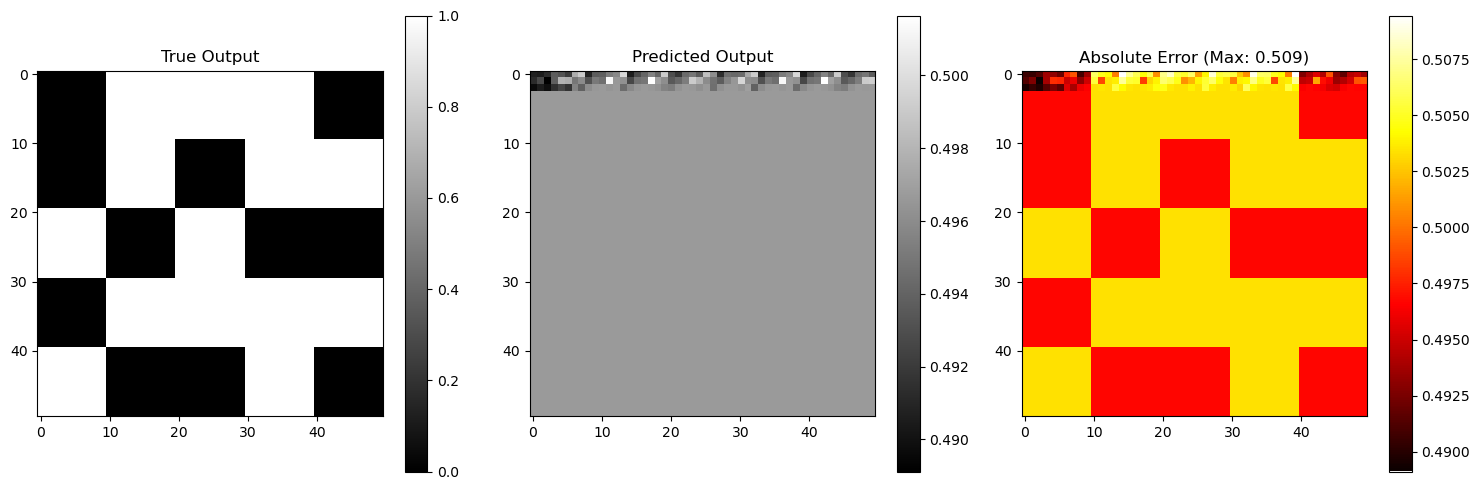


BEST PERFORMING SAMPLES:


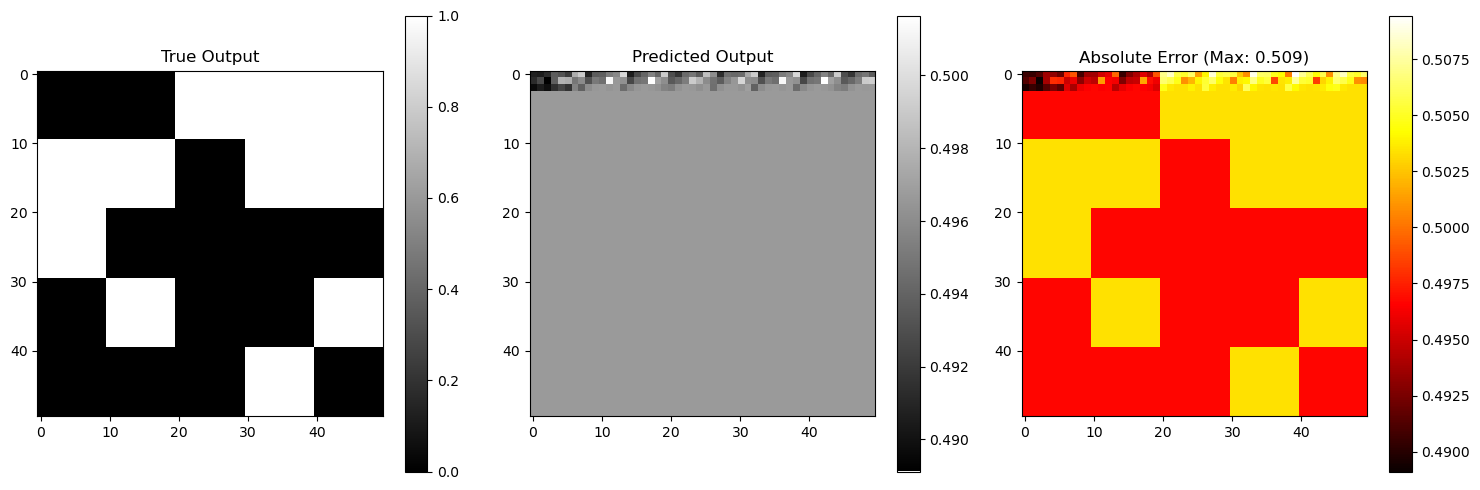

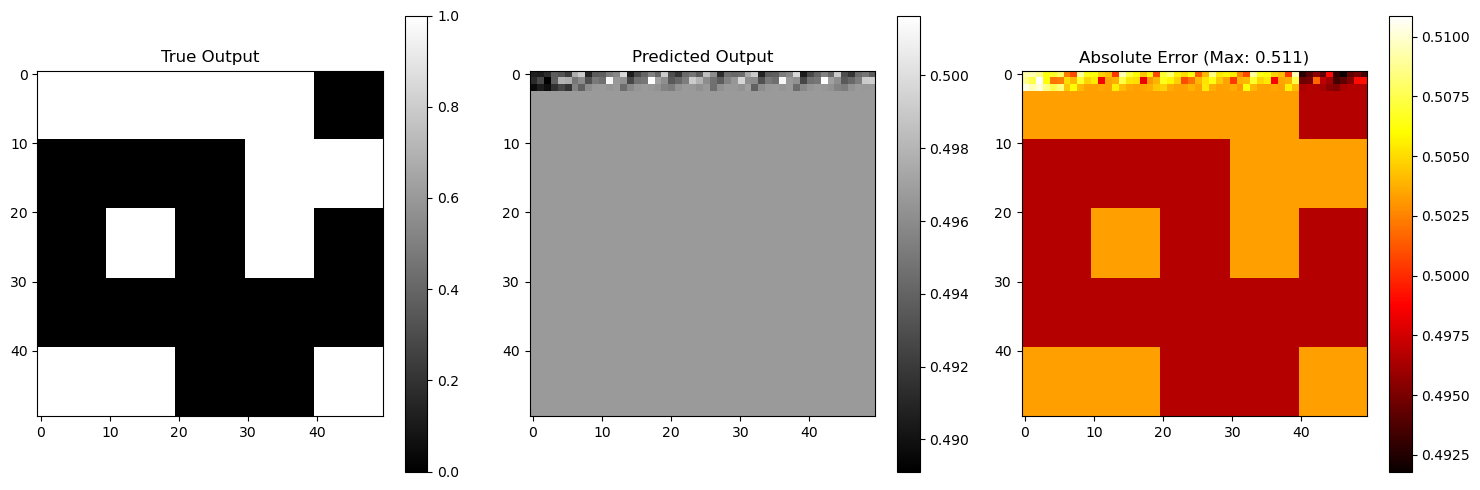

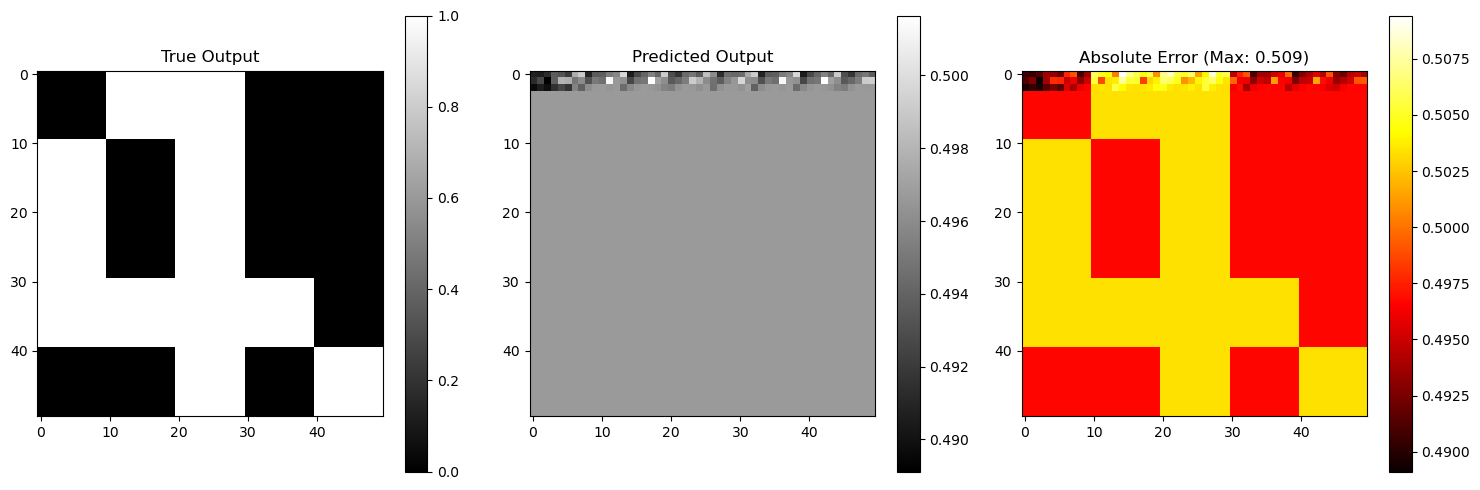

In [19]:
def analyze_extreme_cases(generator, model, n_cases=3):
    inputs, true_outputs = generator[0]
    preds = model.predict(inputs)
    
    # Calculate per-sample MAE
    errors = np.mean(np.abs(true_outputs - preds), axis=(1, 2, 3))
    
    # Sort by error
    sorted_indices = np.argsort(errors)
    
    # Plot worst cases
    print("\nWORST PERFORMING SAMPLES:")
    for i in range(n_cases):
        idx = sorted_indices[-(i+1)]
        plot_error_heatmaps(true_outputs, preds, idx)
    
    # Plot best cases
    print("\nBEST PERFORMING SAMPLES:")
    for i in range(n_cases):
        idx = sorted_indices[i]
        plot_error_heatmaps(true_outputs, preds, idx)

analyze_extreme_cases(train_generator, model)

In [22]:
# Try model architecture modifications
def enhanced_vit_model():
    inputs = layers.Input(shape=input_shape)
    
    # Enhanced patch processing
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Original ViT components
    patches = Patches(patch_size)(x)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Add residual connections
    for _ in range(transformer_layers):
        encoded_patches = transformer_encoder(encoded_patches, projection_dim, num_heads, projection_dim*2)
    
    # Enhanced decoder
    x = layers.Reshape((input_shape[0]//patch_size, input_shape[1]//patch_size, projection_dim))(encoded_patches)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    x = ResizeLayer(output_shape[:2])(x)
    
    return models.Model(inputs=inputs, outputs=x)

In [23]:
# Implement targeted data augmentation
class AugmentedDataGenerator(ImageDataGenerator):
    def __getitem__(self, idx):
        batch_input, batch_output = super().__getitem__(idx)
        
        # Apply random augmentations
        for i in range(len(batch_input)):
            if np.random.rand() > 0.5:
                batch_input[i] = np.fliplr(batch_input[i])
                batch_output[i] = np.fliplr(batch_output[i])
            
            if np.random.rand() > 0.5:
                batch_input[i] = np.flipud(batch_input[i])
                batch_output[i] = np.flipud(batch_output[i])
            
            # Add slight brightness variation
            batch_input[i] = np.clip(batch_input[i] * np.random.uniform(0.9, 1.1), 0, 1)
        
        return batch_input, batch_output